# EPA Air Pollution Research - Impact of COVID-19 on air quality improvement in EJ Communities

## Background (known, known):
* high correlation between low EJ communities and low air quality

## Goal (known, unknown):
* h0: COVID-19 improved air quality equally in all EJ communities (same % improvement)
* h1: COVID-19 improved air quality more/less in low EJ communities (different % improvement)
* control: exclude daily measurement of areas effect by wild fire (identify date, area)

## Procedure:
1. analyze Ozone, PM2.5, demographic data
2. remove data with wild fire effect

# 1.0 Import Tools

Let's import libraries required for this analysis.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib as mpl
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import constants, stats
from datetime import datetime as dt

!pip install researchpy
!pip install openpyxl
!pip install mapbox

import researchpy as rp

from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import plotly
import plotly.figure_factory as ff
import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

from mapbox import Geocoder
geocoder = Geocoder(access_token="pk.eyJ1IjoiamFlbGluMjE1IiwiYSI6ImNsMTgyOWpjNjA5N2IzaWpyZHZoY3hqNXgifQ.mGUBuIT7Il5ZRLKJviaWyw")

     |████████████████████████████████| 242 kB 592 kB/s            


# 2.0 Preprocess Data

Let's load daily average air quality dataset (2019, 2020) from EPA AirNow. For easy manipulation, we will remove any trailing empty spaces from column names and make it all lower case. Let's see how many data point we have from each 2019, 2020.

In [2]:
# import data
epa_2019 = pd.read_excel('../input/phase-ii-widsdatathon2022/epa/epa/Datathon_EPA_Air_Quality_Demographics_Meteorology_2019.xlsx', sheet_name='Sheet1', parse_dates=['DATE'])
epa_2020 = pd.read_excel('../input/phase-ii-widsdatathon2022/epa/epa/Datathon_EPA_Air_Quality_Demographics_Meteorology_2020.xlsx', sheet_name='Sheet1', parse_dates=['DATE'])
#life_expectancy = pd.read_csv('../input/usaleep-life-expectancy/US_B.CSV')

epa_2019 = epa_2019.rename(columns=str.strip)
epa_2019 = epa_2019.rename(columns=str.lower)
epa_2020 = epa_2020.rename(columns=str.strip)
epa_2020 = epa_2020.rename(columns=str.lower)
print('2019 (rows, columns): ', epa_2019.shape)
print('2020 (rows, columns): ', epa_2020.shape)
print('Total daily data points (2019-2022):', epa_2019.shape[0] + epa_2020.shape[0])

2019 (rows, columns):  (129470, 22)
2020 (rows, columns):  (133418, 22)
Total daily data points (2019-2022): 262888


In [3]:
epa_2019

aqs_id   latitude  longitude   county        state  \
0       01-003-0010  30.497478 -87.880258  Baldwin      Alabama   
1       01-003-0010  30.497478 -87.880258  Baldwin      Alabama   
2       01-003-0010  30.497478 -87.880258  Baldwin      Alabama   
3       01-003-0010  30.497478 -87.880258  Baldwin      Alabama   
4       01-003-0010  30.497478 -87.880258  Baldwin      Alabama   
...             ...        ...        ...      ...          ...   
129465  72-021-0010  18.420089 -66.150615  Bayamon  Puerto Rico   
129466  72-021-0010  18.420089 -66.150615  Bayamon  Puerto Rico   
129467  72-021-0010  18.420089 -66.150615  Bayamon  Puerto Rico   
129468  72-021-0010  18.420089 -66.150615  Bayamon  Puerto Rico   
129469  72-021-0010  18.420089 -66.150615  Bayamon  Puerto Rico   

                                cbsa  people_of_color_fraction  \
0          Daphne-Fairhope-Foley, AL                      0.13   
1          Daphne-Fairhope-Foley, AL                      0.13   
2          Daphne-Fairhope-Foley, AL                      0.13   
3          Daphne-Fairhope-Foley, AL                      0.13   
4          Daphne-Fairhope-Foley, AL                      0.13   
...                              ...                       ...   
129465  San Juan-Carolina-Caguas, PR                       NaN   
129466  San Juan-Carolina-Caguas, PR                       NaN   
129467  San Juan-Carolina-Caguas, PR                       NaN   
129468  San Juan-Carolina-Caguas, PR                       NaN   
129469  San Juan-Carolina-Caguas, PR                       NaN   

        low_income_fraction  linguistically_isolated_fraction  \
0                      0.26                               0.0   
1                      0.26                               0.0   
2                      0.26                               0.0   
3                      0.26                               0.0   
4                      0.26                               0.0   
...                     ...                               ...   
129465                  NaN                               NaN   
129466                  NaN                               NaN   
129467                  NaN                               NaN   
129468                  NaN                               NaN   
129469                  NaN                               NaN   

        less_than_hs_ed_fraction  ... relative_humidity  \
0                           0.03  ...               NaN   
1                           0.03  ...               NaN   
2                           0.03  ...               NaN   
3                           0.03  ...               NaN   
4                           0.03  ...               NaN   
...                          ...  ...               ...   
129465                       NaN  ...               NaN   
129466                       NaN  ...               NaN   
129467                       NaN  ...               NaN   
129468                       NaN  ...               NaN   
129469                       NaN  ...               NaN   

        wind_speed_meters_per_second  wind_direction  pm25_ug_per_cubic_meter  \
0                                NaN             NaN                      3.8   
1                                NaN             NaN                      6.5   
2                                NaN             NaN                      8.6   
3                                NaN             NaN                      7.5   
4                                NaN             NaN                      8.8   
...                              ...             ...                      ...   
129465                           NaN             NaN                      4.1   
129466                           NaN             NaN                      4.5   
129467                           NaN             NaN                      3.9   
129468                           NaN             NaN                      6.1   
129469                           N

In [4]:
# merge 2019, 2020 
epa = epa_2019.append(epa_2020)

# rename columns 
old_cols = epa_2019.columns.values.tolist()
new_cols = ['sensor_id','sensor_lat','sensor_long','county','state','cbsa','color','income','language','education','date','temp','humidity','wind_speed','wind_direction','pm25','ozone','no2','co','so2','lead','benzene']
for i in range(len(old_cols)):
    epa = epa.rename(columns={old_cols[i]:new_cols[i]})

# print missing values
print('Missing values (2019-2020): \n')
epa.isnull().sum().sort_values(ascending=False)

Missing values (2019-2020): 



lead              261808
benzene           256775
co                182174
so2               167601
humidity          162805
wind_speed        144653
wind_direction    143075
no2               137459
temp              118340
cbsa               24254
education             91
language              91
income                91
color                 91
date                   0
sensor_lat             0
pm25                   0
ozone                  0
state                  0
county                 0
sensor_long            0
sensor_id              0
dtype: int64

In [5]:
epa[epa.education.isnull()]

sensor_id  sensor_lat  sensor_long   county        state  \
129393  72-021-0010   18.420089   -66.150615  Bayamon  Puerto Rico   
129394  72-021-0010   18.420089   -66.150615  Bayamon  Puerto Rico   
129395  72-021-0010   18.420089   -66.150615  Bayamon  Puerto Rico   
129396  72-021-0010   18.420089   -66.150615  Bayamon  Puerto Rico   
129397  72-021-0010   18.420089   -66.150615  Bayamon  Puerto Rico   
...             ...         ...          ...      ...          ...   
133413  72-021-0010   18.420089   -66.150615  Bayamon  Puerto Rico   
133414  72-021-0010   18.420089   -66.150615  Bayamon  Puerto Rico   
133415  72-021-0010   18.420089   -66.150615  Bayamon  Puerto Rico   
133416  72-021-0010   18.420089   -66.150615  Bayamon  Puerto Rico   
133417  72-021-0010   18.420089   -66.150615  Bayamon  Puerto Rico   

                                cbsa  color  income  language  education  ...  \
129393  San Juan-Carolina-Caguas, PR    NaN     NaN       NaN        NaN  ...   
129394  San Juan-Carolina-Caguas, PR    NaN     NaN       NaN        NaN  ...   
129395  San Juan-Carolina-Caguas, PR    NaN     NaN       NaN        NaN  ...   
129396  San Juan-Carolina-Caguas, PR    NaN     NaN       NaN        NaN  ...   
129397  San Juan-Carolina-Caguas, PR    NaN     NaN       NaN        NaN  ...   
...                              ...    ...     ...       ...        ...  ...   
133413  San Juan-Carolina-Caguas, PR    NaN     NaN       NaN        NaN  ...   
133414  San Juan-Carolina-Caguas, PR    NaN     NaN       NaN        NaN  ...   
133415  San Juan-Carolina-Caguas, PR    NaN     NaN       NaN        NaN  ...   
133416  San Juan-Carolina-Caguas, PR    NaN     NaN       NaN        NaN  ...   
133417  San Juan-Carolina-Caguas, PR    NaN     NaN       NaN        NaN  ...   

       humidity  wind_speed  wind_direction  pm25  ozone  no2        co  \
129393      NaN         NaN             NaN   5.0  0.013  NaN       NaN   
129394      NaN         NaN             NaN  12.3  0.009  NaN       NaN   
129395      NaN         NaN             NaN  11.3  0.010  NaN       NaN   
129396      NaN         NaN             NaN   5.0  0.004  NaN       NaN   
129397      NaN         NaN             NaN   7.1  0.007  NaN       NaN   
...         ...         ...             ...   ...    ...  ...       ...   
133413      NaN         NaN             NaN  16.4  0.022  NaN  0.450000   
133414      NaN         NaN             NaN   2.5  0.017  NaN  0.345833   
133415      NaN         NaN             NaN   6.0  0.025  NaN  0.500000   
133416      NaN         NaN             NaN   6.9  0.020  NaN  0.500000   
133417      NaN         NaN             NaN   5.8  0.019  NaN       NaN   

             so2  lead  benzene  
129393       NaN   NaN      NaN  
129394       NaN   NaN      NaN  
129395       NaN   NaN      NaN  
129396       NaN   NaN      NaN  
129397       NaN   NaN      NaN  
...          ...   ...      ...  
133413  0.295833   NaN      NaN  
133414  0.125000   NaN      NaN  
133415  0.250000   NaN      NaN  
133416       NaN   NaN      NaN  
133417  0.933333   NaN      NaN  

[91 rows x 22 columns]

**No missing data (id, geo-location, important pollutants (Ozone, PM25)):**
* date                   
* sensor_lat                    
* pm25                   
* ozone                  
* state                  
* county                 
* sensor_long                   
* sensor_id                     

**Missing data (a little = demographic data):**
* education             
* language              
* income                
* color                 

**Missing data (a lot = other pollutants, weather, cbsa data):**
* lead              
* benzene         
* co                
* so2               
* humidity          
* wind_speed        
* wind_direction    
* no2               
* temp              
* **cbsa**

`Core-Based Statistical Area (CBSA)` is officially specified by the Office of Management and Budget, the CBSA is the Census summary level representing a “metropolitan area.” Technically, CBSAs are either metropolitan or micropolitan statistical areas—both describe a specific group of counties (or sometimes just one county) around an urban core.

While metro areas vary greatly in size, for some kinds of analysis they are better units of comparison than the single Census place at the core.

In [6]:
epa[['cbsa0', 'cbsa1']] = epa['cbsa'].str.split(',', 1, expand=True)
# df = epa.filter(regex='cbsa?')
# print(df.nunique())

# df = df.reindex(sorted(df.columns), axis=1)
# df.head(2)
epa.head(2)

sensor_id  sensor_lat  sensor_long   county    state  \
0  01-003-0010   30.497478   -87.880258  Baldwin  Alabama   
1  01-003-0010   30.497478   -87.880258  Baldwin  Alabama   

                        cbsa  color  income  language  education  ...  \
0  Daphne-Fairhope-Foley, AL   0.13    0.26       0.0       0.03  ...   
1  Daphne-Fairhope-Foley, AL   0.13    0.26       0.0       0.03  ...   

  wind_direction  pm25  ozone  no2  co  so2  lead  benzene  \
0            NaN   3.8  0.029  NaN NaN  NaN   NaN      NaN   
1            NaN   6.5  0.034  NaN NaN  NaN   NaN      NaN   

                   cbsa0  cbsa1  
0  Daphne-Fairhope-Foley     AL  
1  Daphne-Fairhope-Foley     AL  

[2 rows x 24 columns]

In [7]:
us_states = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
    "District of Columbia": "DC",
    "American Samoa": "AS",
    "Guam": "GU",
    "Northern Mariana Islands": "MP",
    "Puerto Rico": "PR",
    "United States Minor Outlying Islands": "UM",
    "U.S. Virgin Islands": "VI",
}

# invert the dictionary
abbrev_to_us_state = dict(map(reversed, us_states.items()))

In [8]:
epa.head(2)

sensor_id  sensor_lat  sensor_long   county    state  \
0  01-003-0010   30.497478   -87.880258  Baldwin  Alabama   
1  01-003-0010   30.497478   -87.880258  Baldwin  Alabama   

                        cbsa  color  income  language  education  ...  \
0  Daphne-Fairhope-Foley, AL   0.13    0.26       0.0       0.03  ...   
1  Daphne-Fairhope-Foley, AL   0.13    0.26       0.0       0.03  ...   

  wind_direction  pm25  ozone  no2  co  so2  lead  benzene  \
0            NaN   3.8  0.029  NaN NaN  NaN   NaN      NaN   
1            NaN   6.5  0.034  NaN NaN  NaN   NaN      NaN   

                   cbsa0  cbsa1  
0  Daphne-Fairhope-Foley     AL  
1  Daphne-Fairhope-Foley     AL  

[2 rows x 24 columns]

In [9]:
epa['cbsa'].isnull().sum()

24254

In [10]:
# replace NaN to 0
epa['cbsa0'] = epa['cbsa0'].replace(np.nan, 0)
epa['cbsa1'] = epa['cbsa1'].replace(np.nan, 0)
epa['cbsa'] = epa['cbsa'].replace(np.nan, 0)
epa['cbsa0'].isnull().sum()

0

In [11]:
epa.shape

(262888, 24)

In [12]:
epa.head(2)

sensor_id  sensor_lat  sensor_long   county    state  \
0  01-003-0010   30.497478   -87.880258  Baldwin  Alabama   
1  01-003-0010   30.497478   -87.880258  Baldwin  Alabama   

                        cbsa  color  income  language  education  ...  \
0  Daphne-Fairhope-Foley, AL   0.13    0.26       0.0       0.03  ...   
1  Daphne-Fairhope-Foley, AL   0.13    0.26       0.0       0.03  ...   

  wind_direction  pm25  ozone  no2  co  so2  lead  benzene  \
0            NaN   3.8  0.029  NaN NaN  NaN   NaN      NaN   
1            NaN   6.5  0.034  NaN NaN  NaN   NaN      NaN   

                   cbsa0  cbsa1  
0  Daphne-Fairhope-Foley     AL  
1  Daphne-Fairhope-Foley     AL  

[2 rows x 24 columns]

In [13]:
epa = epa.reset_index()
del epa['index']
epa

sensor_id  sensor_lat  sensor_long   county        state  \
0       01-003-0010   30.497478   -87.880258  Baldwin      Alabama   
1       01-003-0010   30.497478   -87.880258  Baldwin      Alabama   
2       01-003-0010   30.497478   -87.880258  Baldwin      Alabama   
3       01-003-0010   30.497478   -87.880258  Baldwin      Alabama   
4       01-003-0010   30.497478   -87.880258  Baldwin      Alabama   
...             ...         ...          ...      ...          ...   
262883  72-021-0010   18.420089   -66.150615  Bayamon  Puerto Rico   
262884  72-021-0010   18.420089   -66.150615  Bayamon  Puerto Rico   
262885  72-021-0010   18.420089   -66.150615  Bayamon  Puerto Rico   
262886  72-021-0010   18.420089   -66.150615  Bayamon  Puerto Rico   
262887  72-021-0010   18.420089   -66.150615  Bayamon  Puerto Rico   

                                cbsa  color  income  language  education  ...  \
0          Daphne-Fairhope-Foley, AL   0.13    0.26       0.0       0.03  ...   
1          Daphne-Fairhope-Foley, AL   0.13    0.26       0.0       0.03  ...   
2          Daphne-Fairhope-Foley, AL   0.13    0.26       0.0       0.03  ...   
3          Daphne-Fairhope-Foley, AL   0.13    0.26       0.0       0.03  ...   
4          Daphne-Fairhope-Foley, AL   0.13    0.26       0.0       0.03  ...   
...                              ...    ...     ...       ...        ...  ...   
262883  San Juan-Carolina-Caguas, PR    NaN     NaN       NaN        NaN  ...   
262884  San Juan-Carolina-Caguas, PR    NaN     NaN       NaN        NaN  ...   
262885  San Juan-Carolina-Caguas, PR    NaN     NaN       NaN        NaN  ...   
262886  San Juan-Carolina-Caguas, PR    NaN     NaN       NaN        NaN  ...   
262887  San Juan-Carolina-Caguas, PR    NaN     NaN       NaN        NaN  ...   

       wind_direction  pm25  ozone  no2        co       so2  lead  benzene  \
0                 NaN   3.8  0.029  NaN       NaN       NaN   NaN      NaN   
1                 NaN   6.5  0.034  NaN       NaN       NaN   NaN      NaN   
2                 NaN   8.6  0.053  NaN       NaN       NaN   NaN      NaN   
3                 NaN   7.5  0.030  NaN       NaN       NaN   NaN      NaN   
4                 NaN   8.8  0.046  NaN       NaN       NaN   NaN      NaN   
...               ...   ...    ...  ...       ...       ...   ...      ...   
262883            NaN  16.4  0.022  NaN  0.450000  0.295833   NaN      NaN   
262884            NaN   2.5  0.017  NaN  0.345833  0.125000   NaN      NaN   
262885            NaN   6.0  0.025  NaN  0.500000  0.250000   NaN      NaN   
262886            NaN   6.9  0.020  NaN  0.500000       NaN   NaN      NaN   
262887            NaN   5.8  0.019  NaN       NaN  0.933333   NaN      NaN   

                           cbsa0  cbsa1  
0          Daphne-Fairhope-Foley     AL  
1          Daphne-Fairhope-Foley     AL  
2          Daphne-Fairhope-Foley     AL  
3          Daphne-Fairhope-Foley     AL  
4          Daphne-Fairhope-Foley     AL  
...                          ...    ...  
262883  San Juan-Carolina-Caguas     PR  
262884  San Juan-Carolina-Caguas     PR  
262885  San Juan-Carolina-Caguas     PR  
262886  San Juan-Carolina-Caguas     PR  
262887  San Juan-Carolina-Caguas     PR  

[262888 rows x 24 columns]

In [14]:
# find index of rows with missing cbsa 
ind = epa.loc[epa.cbsa == 0].index.tolist()

In [15]:
# replace 
old = epa.iloc[ind]['cbsa0'].tolist()
new_cbsa0 = epa.iloc[ind]['county'].tolist()
new_cbsa1 = epa.iloc[ind]['state'].map(us_states).tolist()
#new_cbsa = new_cbsa0.concat(', ', new_cbsa1)

epa.at[ind, 'cbsa0'] = new_cbsa0
# epa.ix['cbsa1', ind] = new_cbsa1
#epa.iloc[ind]['cbsa'] = new_cbsa0 + new_cbsa1
#epa
#epa['cbsa0']
#epa.iloc['cbsa0']


### **`replace 0 values`** with concatenation of other column values

In [16]:
# replace 0 with other values from 'county' and 'state' columns
#df.loc[df[<some_column_name>] == <condition>, [<another_column_name>]] = <value_to_add>

epa.loc[epa.cbsa == 0, ['cbsa0']] = epa.loc[epa.cbsa == 0]['county']
epa.loc[epa.cbsa == 0, ['cbsa1']] = epa['state'].map(us_states)
epa.loc[epa.cbsa == 0, ['cbsa']] = epa.loc[epa.cbsa == 0]['cbsa0'] + ', ' + epa.loc[epa.cbsa == 0]['cbsa1']

# check the updated values
epa[epa.county == epa.cbsa0]

sensor_id  sensor_lat  sensor_long    county    state          cbsa  \
633     01-097-0003   30.770181   -88.087761    Mobile  Alabama    Mobile, AL   
634     01-097-0003   30.770181   -88.087761    Mobile  Alabama    Mobile, AL   
635     01-097-0003   30.770181   -88.087761    Mobile  Alabama    Mobile, AL   
636     01-097-0003   30.770181   -88.087761    Mobile  Alabama    Mobile, AL   
637     01-097-0003   30.770181   -88.087761    Mobile  Alabama    Mobile, AL   
...             ...         ...          ...       ...      ...           ...   
262545  56-035-0101   42.869824  -109.870760  Sublette  Wyoming  Sublette, WY   
262546  56-035-0101   42.869824  -109.870760  Sublette  Wyoming  Sublette, WY   
262547  56-035-0101   42.869824  -109.870760  Sublette  Wyoming  Sublette, WY   
262548  56-035-0101   42.869824  -109.870760  Sublette  Wyoming  Sublette, WY   
262549  56-035-0101   42.869824  -109.870760  Sublette  Wyoming  Sublette, WY   

        color  income  language  education  ... wind_direction  pm25  ozone  \
633      0.43    0.56       0.0       0.15  ...            NaN   6.4  0.032   
634      0.43    0.56       0.0       0.15  ...            NaN   8.9  0.044   
635      0.43    0.56       0.0       0.15  ...            NaN   8.9  0.025   
636      0.43    0.56       0.0       0.15  ...            NaN   9.7  0.031   
637      0.43    0.56       0.0       0.15  ...            NaN   3.7  0.034   
...       ...     ...       ...        ...  ...            ...   ...    ...   
262545   0.06    0.24       0.0       0.01  ...            NaN   1.0  0.039   
262546   0.06    0.24       0.0       0.01  ...            NaN   1.1  0.041   
262547   0.06    0.24       0.0       0.01  ...            NaN  -0.5  0.043   
262548   0.06    0.24       0.0       0.01  ...            NaN  -1.0  0.045   
262549   0.06    0.24       0.0       0.01  ...            NaN  -1.0  0.044   

             no2  co       so2  lead  benzene     cbsa0  cbsa1  
633          NaN NaN  0.886957   NaN      NaN    Mobile     AL  
634          NaN NaN  0.868182   NaN      NaN    Mobile     AL  
635          NaN NaN  0.713043   NaN      NaN    Mobile     AL  
636          NaN NaN  0.730435   NaN      NaN    Mobile     AL  
637          NaN NaN  1.147826   NaN      NaN    Mobile     AL  
...          ...  ..       ...   ...      ...       ...    ...  
262545  1.466667 NaN       NaN   NaN      NaN  Sublette     WY  
262546  2.439130 NaN       NaN   NaN      NaN  Sublette     WY  
262547  1.525000 NaN       NaN   NaN      NaN  Sublette     WY  
262548  1.020833 NaN       NaN   NaN      NaN  Sublette     WY  
262549  1.373913 NaN       NaN   NaN      NaN  Sublette     WY  

[39441 rows x 24 columns]

-----------------
## Export to CSV (EPA preprocessed - CBSA filled)
-----------------

In [17]:
epa.to_csv('epa_preprocessed.csv')

## Check Number of Sensors, Unique Dates per each EJ Community (CBSA)

In [18]:
print('Counts of Sensors, Daily data points: ')
counts_df = epa.groupby(by='cbsa').agg('nunique')
summary_counts = counts_df[['sensor_id', 'date']].sort_values('sensor_id', ascending=False)
summary_counts
#summary_counts.describe()
#summary_counts.shape

Counts of Sensors, Daily data points: 


sensor_id  date
cbsa                                                        
Riverside-San Bernardino-Ontario, CA                11   729
Chicago-Naperville-Elgin, IL-IN-WI                  10   729
Pittsburgh, PA                                      10   729
Los Angeles-Long Beach-Anaheim, CA                   9   729
Philadelphia-Camden-Wilmington, PA-NJ-DE-MD          9   729
...                                                ...   ...
Hartford-West Hartford-East Hartford, CT             1   707
Helena, MT                                           1   682
Hobbs, NM                                            1   663
Holland, MI                                          1   347
Yuma, AZ                                             1   710

[306 rows x 2 columns]

**Summary counts:**

* Unique CBSA Communities: 306
* Unique Sensors: 1-11 (median = 1.0)
* Unique Dates: 41-729 (median = 640)

## Date -> Year, Month, Date:

In [19]:
epa['year'] = pd.DatetimeIndex(pd.to_datetime(epa['date'])).year
epa['month'] = pd.DatetimeIndex(pd.to_datetime(epa['date'])).month
epa['day'] = pd.DatetimeIndex(pd.to_datetime(epa['date'])).day
epa['weekday'] = epa['date'].dt.dayofweek
epa.head(2)

sensor_id  sensor_lat  sensor_long   county    state  \
0  01-003-0010   30.497478   -87.880258  Baldwin  Alabama   
1  01-003-0010   30.497478   -87.880258  Baldwin  Alabama   

                        cbsa  color  income  language  education  ...  co  \
0  Daphne-Fairhope-Foley, AL   0.13    0.26       0.0       0.03  ... NaN   
1  Daphne-Fairhope-Foley, AL   0.13    0.26       0.0       0.03  ... NaN   

   so2  lead  benzene                  cbsa0  cbsa1  year  month  day  weekday  
0  NaN   NaN      NaN  Daphne-Fairhope-Foley     AL  2019      3    1        4  
1  NaN   NaN      NaN  Daphne-Fairhope-Foley     AL  2019      3    4        0  

[2 rows x 28 columns]

# 3.0 Analyze Data (Important pollutants + Demographic)

## 3.1 Primary Pollutants
According to numerous studies, ozone and fine particulates (PM25) have the most siginificant health impact to humans. Therefore, let's identify if the concentration of these pollutants have been increasing/decreasing due to COVID-19.

In [20]:
epa_primary_pollutants = epa[['cbsa', 'cbsa0','cbsa1','date','year','month','day','weekday','ozone','pm25']]
epa_primary_pollutants = epa_primary_pollutants.set_index('date')

------------------
## Export to CSV (preprocessed EPA Primary Pollutants)
------------------

In [21]:
epa_primary_pollutants.to_csv('primary_pollutants.csv')
epa_primary_pollutants

cbsa                     cbsa0 cbsa1  \
date                                                                       
2019-03-01     Daphne-Fairhope-Foley, AL     Daphne-Fairhope-Foley    AL   
2019-03-04     Daphne-Fairhope-Foley, AL     Daphne-Fairhope-Foley    AL   
2019-03-07     Daphne-Fairhope-Foley, AL     Daphne-Fairhope-Foley    AL   
2019-03-10     Daphne-Fairhope-Foley, AL     Daphne-Fairhope-Foley    AL   
2019-03-13     Daphne-Fairhope-Foley, AL     Daphne-Fairhope-Foley    AL   
...                                  ...                       ...   ...   
2020-10-30  San Juan-Carolina-Caguas, PR  San Juan-Carolina-Caguas    PR   
2020-11-11  San Juan-Carolina-Caguas, PR  San Juan-Carolina-Caguas    PR   
2020-11-14  San Juan-Carolina-Caguas, PR  San Juan-Carolina-Caguas    PR   
2020-11-17  San Juan-Carolina-Caguas, PR  San Juan-Carolina-Caguas    PR   
2020-11-23  San Juan-Carolina-Caguas, PR  San Juan-Carolina-Caguas    PR   

            year  month  day  weekday  ozone  pm25  
date                                                
2019-03-01  2019      3    1        4  0.029   3.8  
2019-03-04  2019      3    4        0  0.034   6.5  
2019-03-07  2019      3    7        3  0.053   8.6  
2019-03-10  2019      3   10        6  0.030   7.5  
2019-03-13  2019      3   13        2  0.046   8.8  
...          ...    ...  ...      ...    ...   ...  
2020-10-30  2020     10   30        4  0.022  16.4  
2020-11-11  2020     11   11        2  0.017   2.5  
2020-11-14  2020     11   14        5  0.025   6.0  
2020-11-17  2020     11   17        1  0.020   6.9  
2020-11-23  2020     11   23        0  0.019   5.8  

[262888 rows x 9 columns]

In [22]:
data_2019 = pd.DataFrame(epa_primary_pollutants['2019-01-01':'2019-12-31'])
data_2020 = pd.DataFrame(epa_primary_pollutants['2019-01-01':'2019-12-31'])
before_covid = pd.DataFrame(epa_primary_pollutants['2019-01-01':'2020-03-31'])
during_covid = pd.DataFrame(epa_primary_pollutants['2020-04-01':'2019-12-31'])

data_all = epa_primary_pollutants

## 3.1.1 US-wide Primary Pollutants (2019-2020)

Some spikes are observed around September 2020. Let's investigate **wild fire** events around this time.

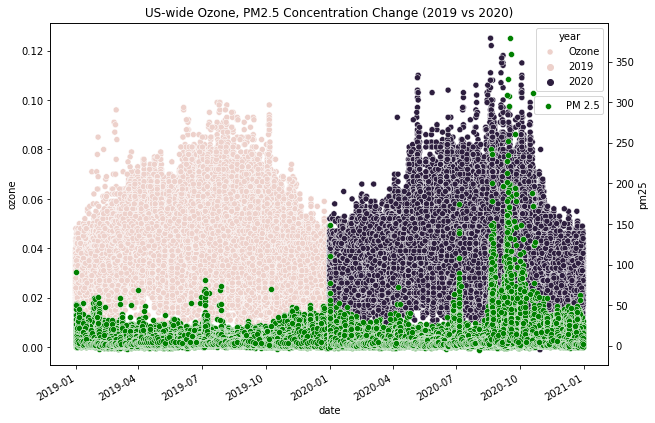

In [23]:
fig, ax = plt.subplots(1,1, figsize=(10,7))
ax.set(title='US-wide Ozone, PM2.5 Concentration Change (2019 vs 2020)')

g1 = sns.scatterplot(data=data_all, x=data_all.index, y='ozone', label='Ozone', hue='year')
ax2 = plt.twinx()
g2 = sns.scatterplot(data=data_all, x=data_all.index, y='pm25', label='PM 2.5', ax=ax2, color='green')
sns.move_legend(g1, "upper right", bbox_to_anchor=(1., 1))
sns.move_legend(g2, "upper right", bbox_to_anchor=(1., 0.8))
fig.autofmt_xdate()
plt.show()

## 3.1.2 New York Pollutants (2019-2020)

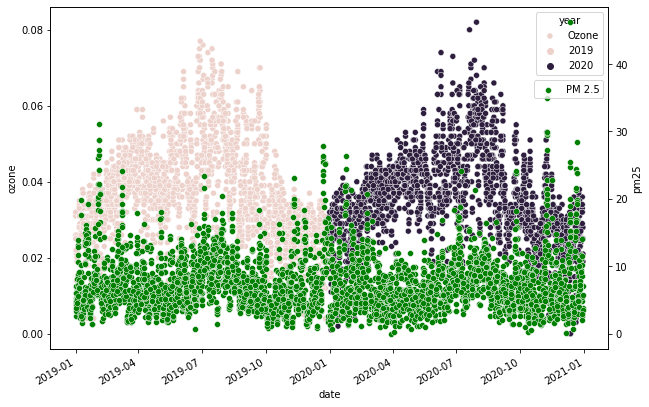

In [24]:
data_ny = epa_primary_pollutants[epa_primary_pollutants.cbsa.str.contains('New York')]

fig, ax = plt.subplots(1,1, figsize=(10,7))
g1 = sns.scatterplot(x=data_ny.index, y='ozone', data=data_ny, hue='year', label='Ozone')
ax2 = plt.twinx()
g2 = sns.scatterplot(x=data_ny.index, y='pm25', data=data_ny, color='green', ax=ax2, label='PM 2.5')
sns.move_legend(g1, "upper right", bbox_to_anchor=(1., 1))
sns.move_legend(g2, "upper right", bbox_to_anchor=(1., 0.8))
fig.autofmt_xdate()
plt.show()

# 3.2 Wile Fire Impact

## 3.2.1 California Wild Fire (2020)

In 2020, California wiledfires started Feb 15 and lasted until Dec 31. Let's filter the rows by 'cbsa1 = CA'and see any spikes are observed in pollutant concentration. This will inform us the signature of wildfile in our dataset. Then, we can look for similar trends in other areas. COVID-19 lockdown impact can only be analyzed properly when we isolate wild fire impact. Let's start by looking at California region.

In [25]:
# california data
ca = epa_primary_pollutants[epa_primary_pollutants.cbsa1 == 'CA']
ca

cbsa      cbsa0 cbsa1  year  month  day  weekday  ozone  \
date                                                                           
2019-01-01  Calaveras, CA  Calaveras    CA  2019      1    1        1  0.030   
2019-01-02  Calaveras, CA  Calaveras    CA  2019      1    2        2  0.028   
2019-01-12  Calaveras, CA  Calaveras    CA  2019      1   12        5  0.036   
2019-01-13  Calaveras, CA  Calaveras    CA  2019      1   13        6  0.031   
2019-01-14  Calaveras, CA  Calaveras    CA  2019      1   14        0  0.028   
...                   ...        ...   ...   ...    ...  ...      ...    ...   
2020-12-26   Siskiyou, CA   Siskiyou    CA  2020     12   26        5  0.028   
2020-12-27   Siskiyou, CA   Siskiyou    CA  2020     12   27        6  0.016   
2020-12-28   Siskiyou, CA   Siskiyou    CA  2020     12   28        0  0.022   
2020-12-29   Siskiyou, CA   Siskiyou    CA  2020     12   29        1  0.017   
2020-12-30   Siskiyou, CA   Siskiyou    CA  2020     12   30        2  0.019   

            pm25  
date              
2019-01-01  17.9  
2019-01-02  24.8  
2019-01-12   6.7  
2019-01-13   7.5  
2019-01-14  10.0  
...          ...  
2020-12-26   5.7  
2020-12-27  10.0  
2020-12-28  11.7  
2020-12-29  11.1  
2020-12-30  13.5  

[1505 rows x 9 columns]

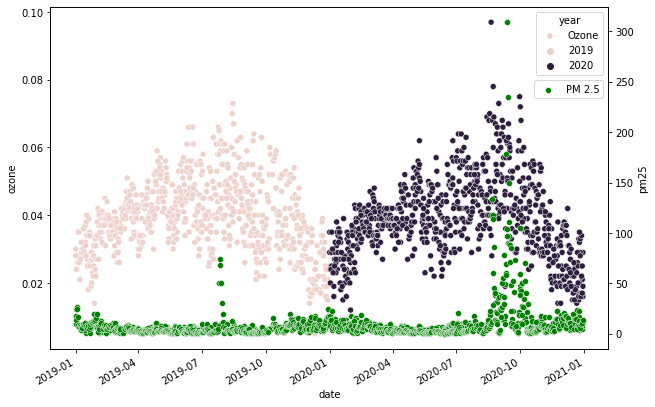

In [26]:
# visualize california data
data_ca = ca

fig, ax = plt.subplots(1,1, figsize=(10,7))
g1 = sns.scatterplot(x=data_ca.index, y='ozone', data=data_ca, hue='year', label='Ozone')
ax2 = plt.twinx()
g2 = sns.scatterplot(x=data_ca.index, y='pm25', data=data_ca, color='green', ax=ax2, label='PM 2.5')
sns.move_legend(g1, "upper right", bbox_to_anchor=(1., 1))
sns.move_legend(g2, "upper right", bbox_to_anchor=(1., 0.8))
fig.autofmt_xdate()
plt.show()

Based on the spikes of PM 2.5 concentration, we can suspect California Wild Fire likely happend around these dates:

* 2019-08-20 (spike)
* 2020-01-01 (spike)
* 2020-08-17 (lasting started)
* 2020-09-15 (lasting peak)
* 2020-10-10 (lasting ended, after 2 months)


# 3.3. COVID-19 Impact

**2020**
* Mar 19: California lock down
* Mar/Apr: World lock down
* May: re-opening


# 4.0 Geolocation Mapping

In [27]:
df = epa

geometry = [Point(xy) for xy in zip(df['sensor_long'], df['sensor_lat'])]
gdf = GeoDataFrame(df, geometry=geometry)   
gdf.head(2)

sensor_id  sensor_lat  sensor_long   county    state  \
0  01-003-0010   30.497478   -87.880258  Baldwin  Alabama   
1  01-003-0010   30.497478   -87.880258  Baldwin  Alabama   

                        cbsa  color  income  language  education  ... so2  \
0  Daphne-Fairhope-Foley, AL   0.13    0.26       0.0       0.03  ... NaN   
1  Daphne-Fairhope-Foley, AL   0.13    0.26       0.0       0.03  ... NaN   

   lead  benzene                  cbsa0  cbsa1  year  month  day  weekday  \
0   NaN      NaN  Daphne-Fairhope-Foley     AL  2019      3    1        4   
1   NaN      NaN  Daphne-Fairhope-Foley     AL  2019      3    4        0   

                     geometry  
0  POINT (-87.88026 30.49748)  
1  POINT (-87.88026 30.49748)  

[2 rows x 29 columns]

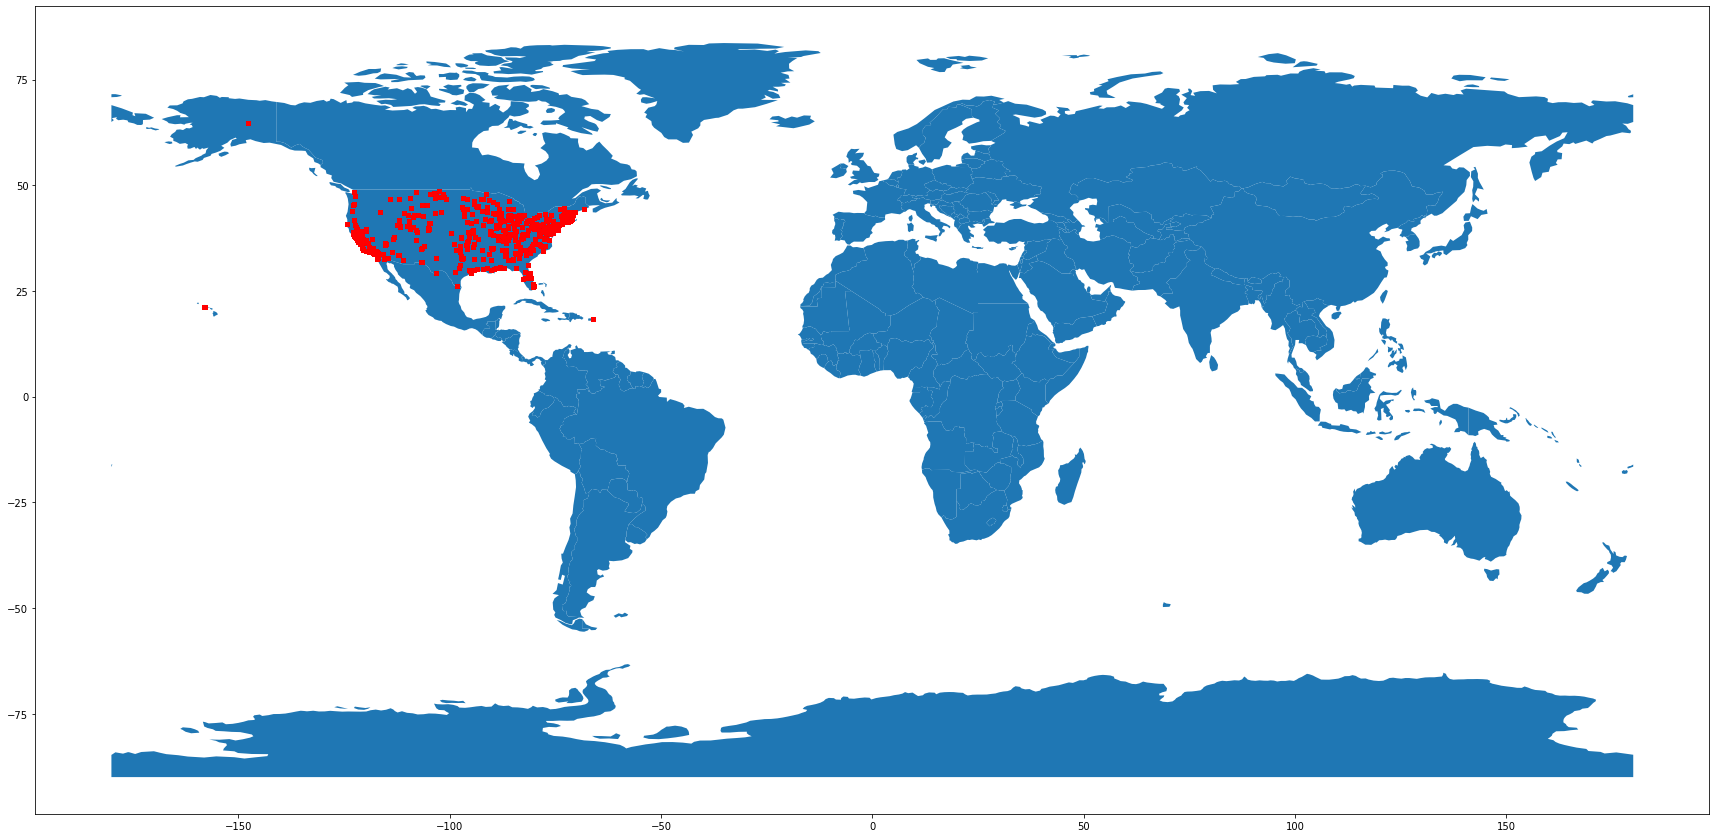

In [28]:
#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(30, 18)), marker='o', color='red', markersize=15);

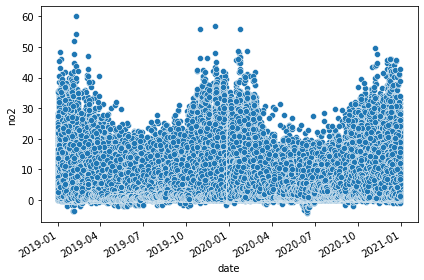

In [29]:
fig, ax = plt.subplots(1,1)
ax = sns.scatterplot(data=epa, x='date',y='no2')
#ax.get_legend().remove()
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

In [30]:
epa.head(2)

sensor_id  sensor_lat  sensor_long   county    state  \
0  01-003-0010   30.497478   -87.880258  Baldwin  Alabama   
1  01-003-0010   30.497478   -87.880258  Baldwin  Alabama   

                        cbsa  color  income  language  education  ... so2  \
0  Daphne-Fairhope-Foley, AL   0.13    0.26       0.0       0.03  ... NaN   
1  Daphne-Fairhope-Foley, AL   0.13    0.26       0.0       0.03  ... NaN   

   lead  benzene                  cbsa0  cbsa1  year  month  day  weekday  \
0   NaN      NaN  Daphne-Fairhope-Foley     AL  2019      3    1        4   
1   NaN      NaN  Daphne-Fairhope-Foley     AL  2019      3    4        0   

                     geometry  
0  POINT (-87.88026 30.49748)  
1  POINT (-87.88026 30.49748)  

[2 rows x 29 columns]

# 5.0 Missing Data (per EJ Community)

## 5.1 Missing Ozone data

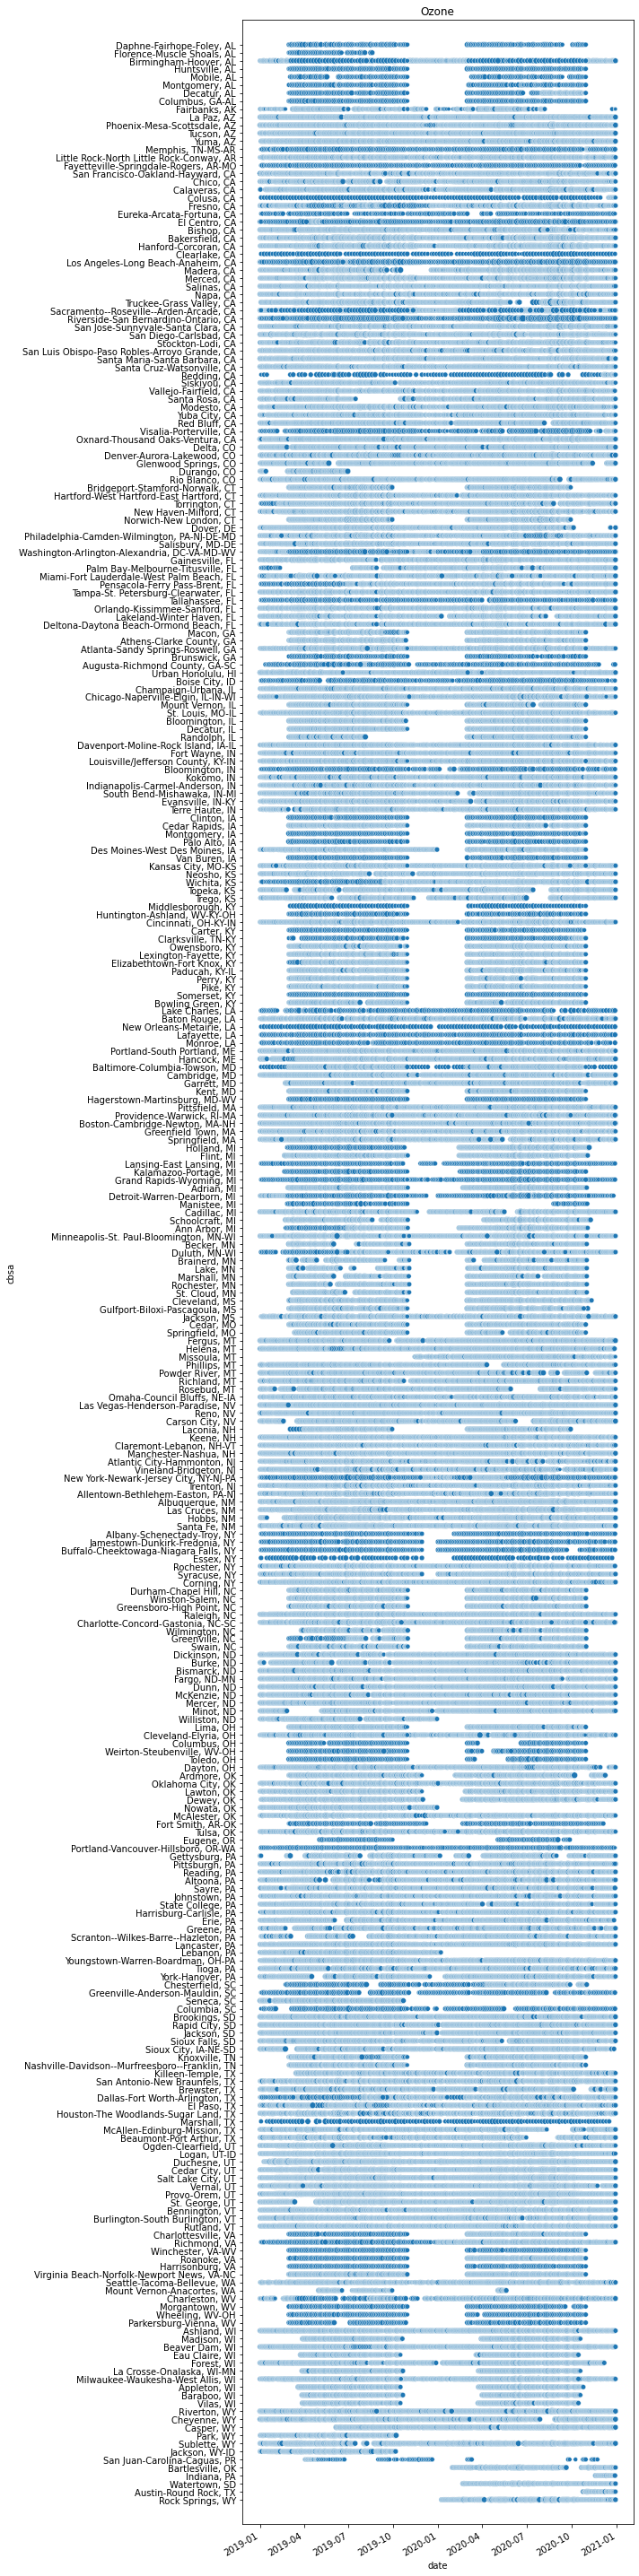

In [31]:
fig, ax = plt.subplots(1,1, figsize=(10,40))
ax = sns.scatterplot(x='date', y='cbsa', data = epa, size='ozone',markers='.')
ax.set(title='Ozone')
ax.get_legend().remove()
ax.set(autoscaley_on=True,ymargin=0.01)
fig.autofmt_xdate()
plt.tight_layout()

## 5.2 Missing PM 2.5 data

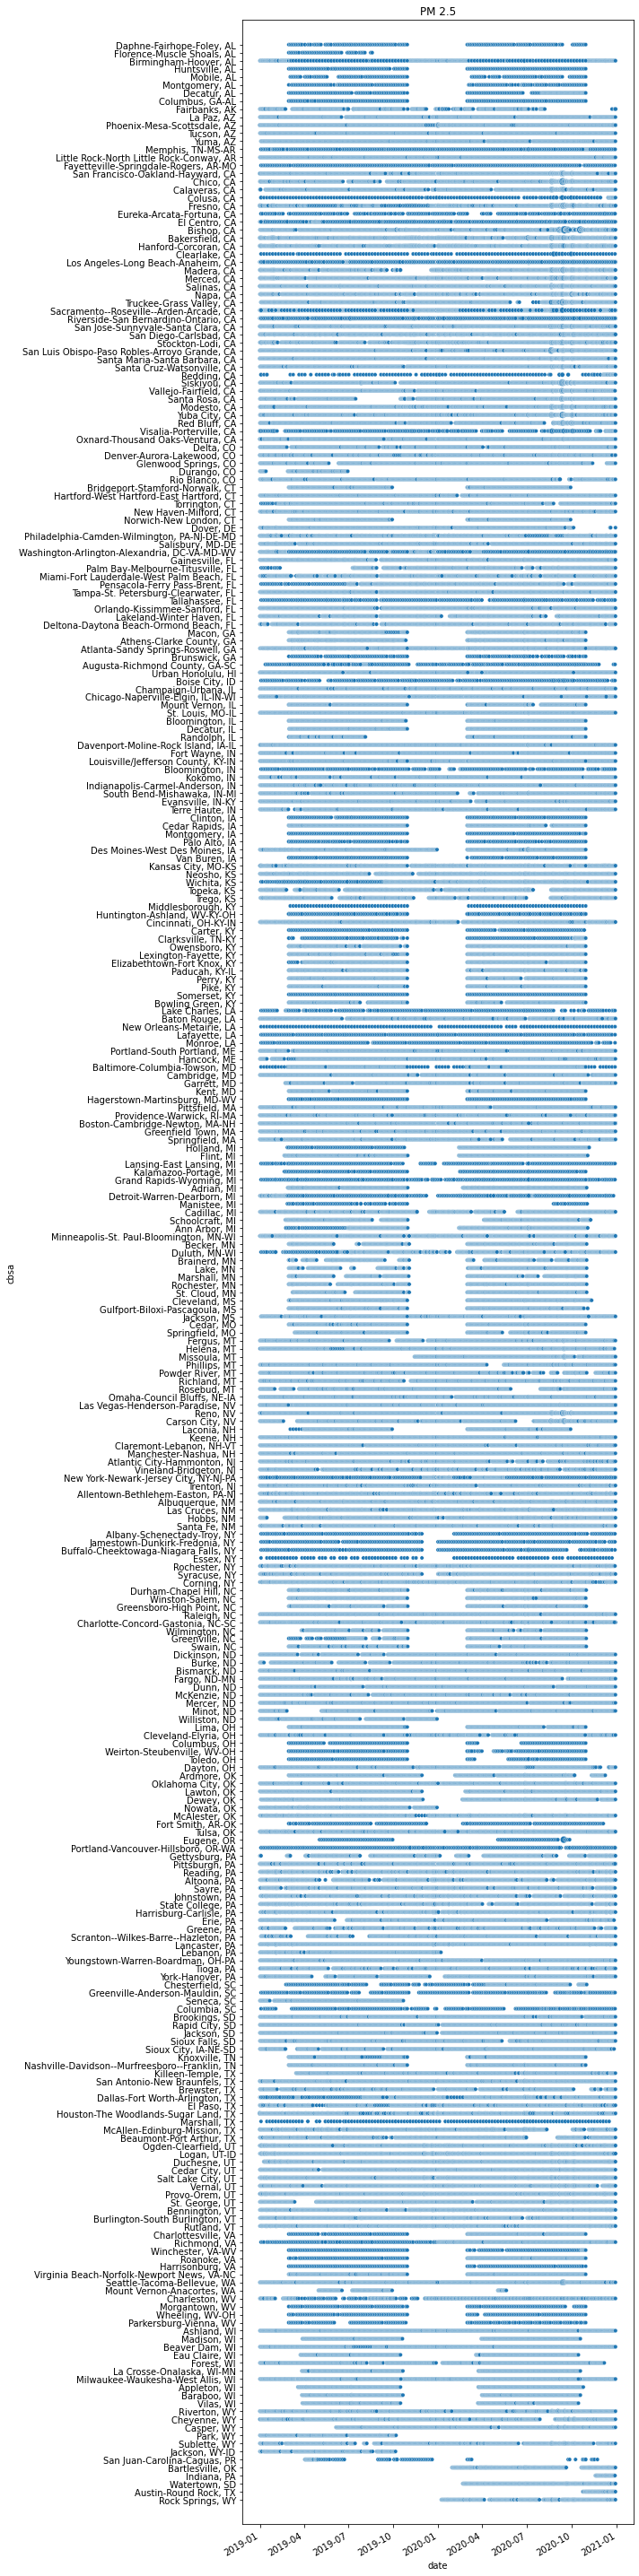

In [32]:
fig, ax = plt.subplots(1,1, figsize=(10,40))
ax = sns.scatterplot(x='date', y='cbsa', data = epa, size='pm25',markers='.')
ax.set(title='PM 2.5')
ax.get_legend().remove()
ax.set(autoscaley_on=True,ymargin=0.01)
fig.autofmt_xdate()
plt.tight_layout()

## 5.3 Missing NO2 data

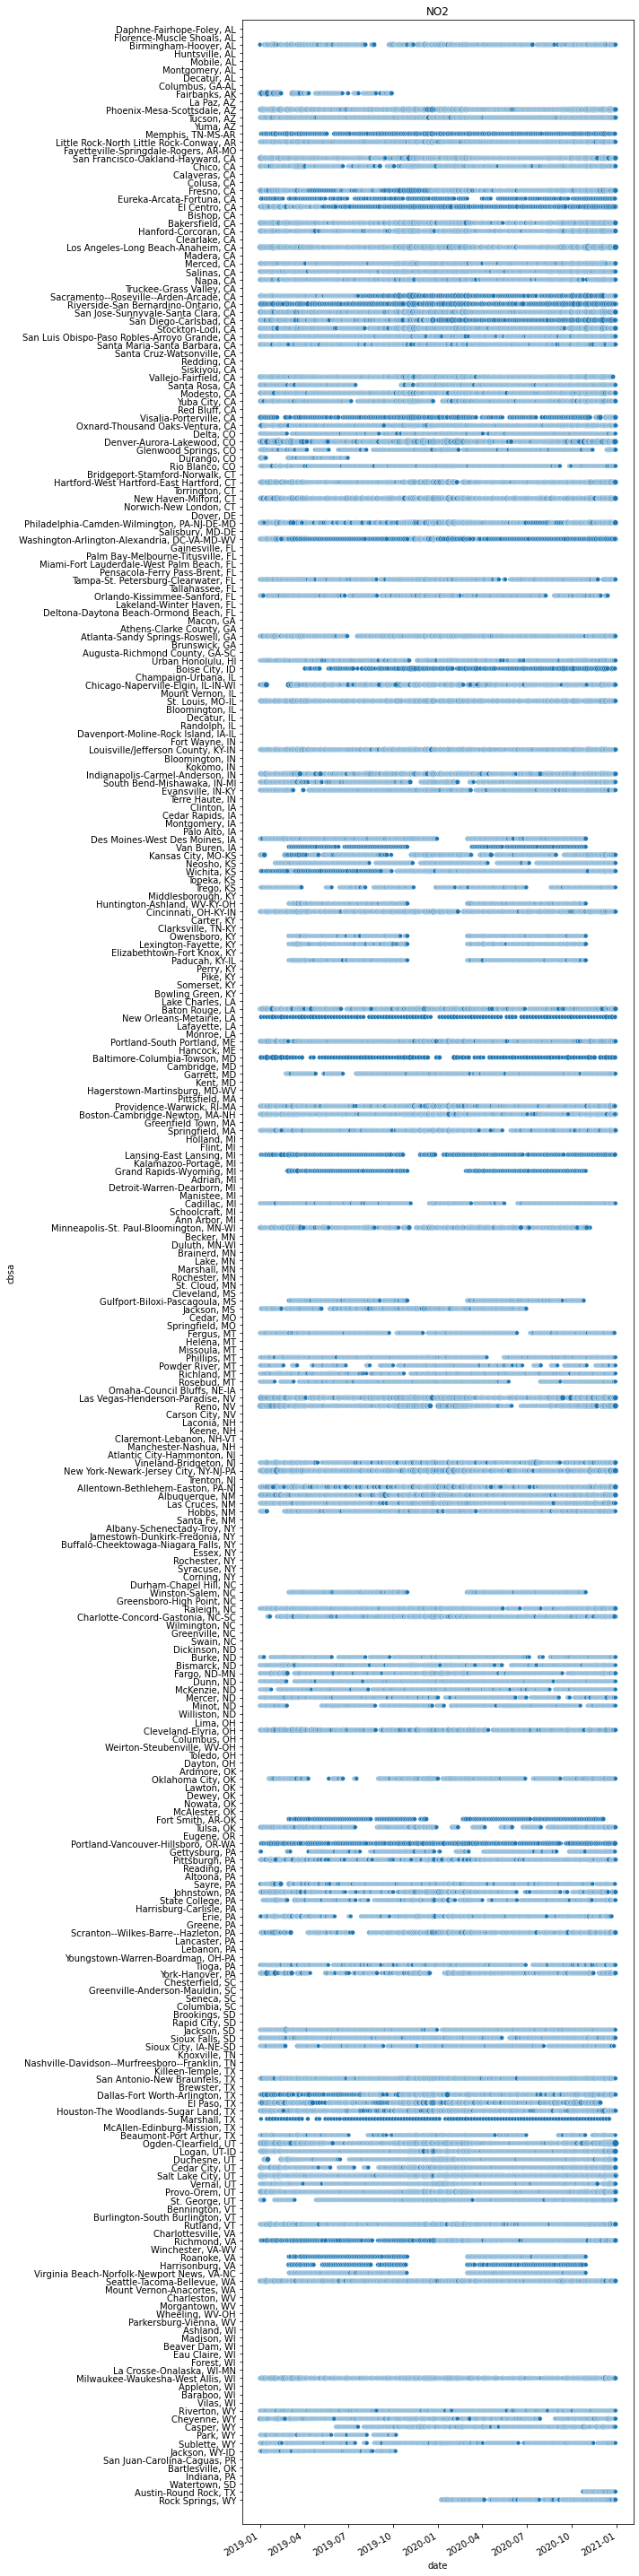

In [33]:
fig, ax = plt.subplots(1,1, figsize=(10,40))
ax = sns.scatterplot(x='date', y='cbsa', data = epa, size='no2',markers='.')
ax.set(title='NO2')
ax.get_legend().remove()
ax.set(autoscaley_on=True,ymargin=0.01)
fig.autofmt_xdate()
plt.tight_layout()

# 6.0 Demographic & Air Pollution (COVID-19 impact)

In [34]:
color_co = epa.groupby('cbsa').agg({'color': ['mean', 'count'], 'co': 'mean'}).sort_values([('co', 'mean')], ascending=False)
color_co_clean = color_co.dropna()
color_co_clean

color              co
                                       mean count      mean
cbsa                                                       
Vernal, UT                         0.177013   790  1.291684
Grand Rapids-Wyoming, MI           0.111756   393  0.422672
Detroit-Warren-Dearborn, MI        0.395976   989  0.418511
San Francisco-Oakland-Hayward, CA  0.585638  6307  0.395766
Orlando-Kissimmee-Sanford, FL      0.339740  1386  0.368394
...                                     ...   ...       ...
Johnstown, PA                      0.370000   670  0.101556
Gettysburg, PA                     0.040000   517  0.075699
Champaign-Urbana, IL               0.070000   689  0.066368
Erie, PA                           0.600000   671  0.050982
Columbia, SC                       0.870000   217  0.037785

[96 rows x 3 columns]

# 7.0 Correlation

In [35]:
corr = epa.corr()

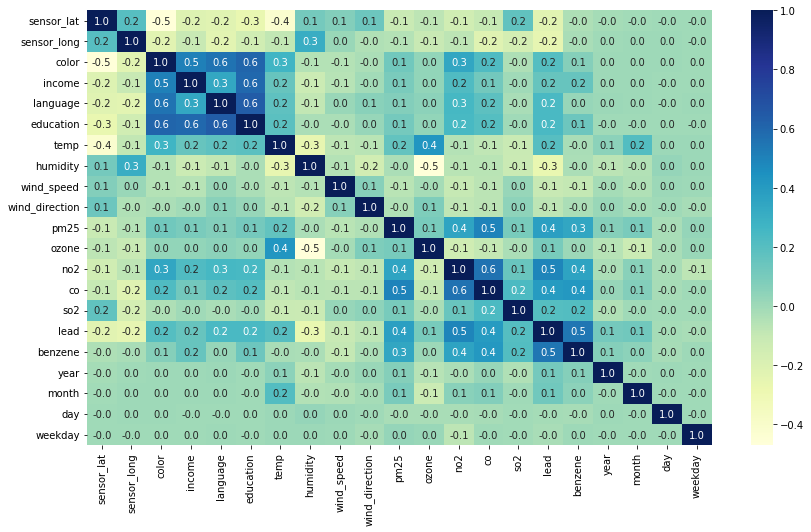

In [36]:
mask = np.zeros_like(corr)
fig, ax = plt.subplots(figsize=(14,8)) 
sns.heatmap(corr, mask=mask, cmap="YlGnBu", ax=ax, annot=True, fmt='.1f')
plt.show()

Strong **POSITIVE CORRELATION** between PEOPLE_OF_COLOR_FRACTION, LOW_INCOME_FRACTION, LINGUISTICALLY_ISOLATED_FRACTION, LESS_THAN_HS_EDUCATION_FRACTION
Strong **POSITIVE CORRELATION** between NO2_PPM, CO_PPM, BENZENE_PPMBC,

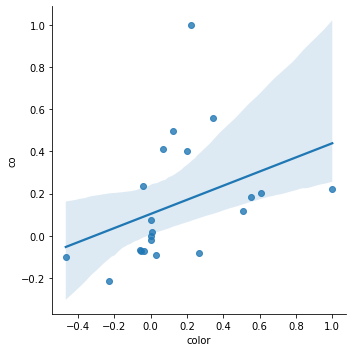

In [37]:
sns.lmplot(data=corr, x='color', y='co')